In [1]:
import gymnasium as gym
import numpy as np
from wrappers.deploy_policy import DeployPolicy
from gym.wrappers import RecordVideo
from time import sleep

with open('windy_gridworld_optimal.npy', 'rb') as f:
    policy = np.load(f)

#with open('windy_gridworld_behavior.npy', 'rb') as f:
#    policy = np.load(f)
    
with open('windy_gridworld_optimal_values.npy', 'rb') as f:
    opt_val = np.load(f)

with open('windy_gridworld_transition.npy', 'rb') as f:
    opt_ps = np.load(f)

env = gym.make('causal_gym/WindyGridWorld-v0', size = 3)


pygame 2.5.2 (SDL 2.28.3, Python 3.11.7)
Hello from the pygame community. https://www.pygame.org/contribute.html
[[[2 2 2]
  [2 2 2]
  [1 0 3]]

 [[2 2 2]
  [2 2 2]
  [0 0 0]]

 [[1 2 2]
  [1 0 3]
  [1 0 3]]

 [[2 2 2]
  [2 2 2]
  [3 0 2]]

 [[1 2 3]
  [2 2 2]
  [2 0 2]]]


In [2]:
import numpy as np
q_table = np.zeros([env.size, env.size, env.action_space.n])

/opt/homebrew/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.size to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.size` for environment variables or `env.get_wrapper_attr('size')` that will search the reminding wrappers.
  logger.warn(


In [3]:
"""Training the agent"""

import random
from IPython.display import clear_output

# Hyperparameters
alpha = 0.1
gamma = 1
epsilon = 1

# For plotting metrics
all_epochs = []
all_penalties = []

for i in range(1, 50001):
    state, _ = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False
    terminated = False
    
    while not done and not terminated:
        action = policy[state['agent'][0],state['agent'][1]]
        next_state, reward, done, terminated, info = env.step(action) 

        #action, next_state, reward, done, terminated, info = env.see() 

        old_value = q_table[state['agent'][0], state['agent'][1], action]
        next_max = np.max(q_table[next_state['agent'][0], next_state['agent'][1]])

        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state['agent'][0], state['agent'][1], action] = new_value

        state = next_state
        epochs += 1
        
    if i % 1000 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")

Episode: 50000
Training finished.



In [4]:
print(np.transpose(q_table))
print(np.transpose(np.max(q_table, axis=2)))
print(np.transpose(np.argmax(q_table, axis=2)))

policy = np.argmax(q_table, axis=2)

[[[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[-1.  0.  0.]
  [-1.  0.  0.]
  [-1.  0.  0.]]

 [[ 0. -1.  0.]
  [ 0. -1.  0.]
  [ 0.  0.  0.]]

 [[ 0.  0. -1.]
  [ 0.  0. -1.]
  [ 0.  0. -1.]]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0 0 0]
 [0 0 0]
 [0 0 0]]


In [5]:
def value_iteration(ps, policy):
    theta = 0.1
    max_iterations = 10
    gamma = 1 
    values = np.zeros([env.size, env.size])
    for j in range(max_iterations):
        err = 0.0
        new_values = np.zeros([env.size, env.size])
        for x in range(env.size):
            for y in range(env.size):
                qtable = np.zeros(env.action_space.n)

                if x != int(env.size / 2) or y != int(env.size - 1):
                    for a in range(env.action_space.n):
                        # Calculate the value of Q(s,a)
                        new_value = -1
                        for new_x in range(env.size):
                            for new_y in range(env.size):
                                new_value += ps[x, y, a, new_x, new_y] * gamma * values[new_x, new_y]

                        qtable[a] = new_value

                max_q = np.mean(qtable)

                err = np.max([err, np.abs(values[x, y] - max_q)])
                new_values[x, y] = max_q

        values = new_values
        # Terminate if the value function has converged
        if err < theta:
            break
        
    return values

In [6]:
T = 1000
K = 100

regrets = np.zeros(T)

In [7]:
"""Training the agent"""

import random
from IPython.display import clear_output

# Hyperparameters
alpha = 0.1
gamma = 1
delta = 0.1

values = value_iteration(opt_ps, policy)

for k in range(K):
    regret = 0
    for i in range(T):
        state, _ = env.reset()

        opt_v = opt_val[state['agent'][0], state['agent'][1]]
        rewards = values[state['agent'][0], state['agent'][1]]

        regret += opt_v - rewards
        regrets[i] += regret

print("Training finished.\n")
regrets = regrets / K

Training finished.



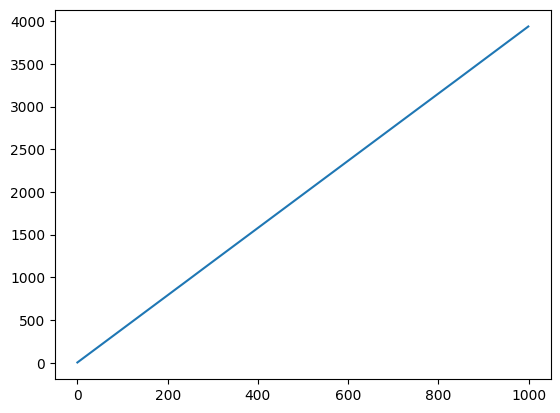

In [8]:

import matplotlib.pyplot as plt
plt.plot(range(T), regrets)
plt.show()

In [9]:
with open('windy_gridworld_confounded.regret', 'wb') as f:
    np.save(f, regrets)


In [11]:
"""Evaluate agent's performance after Q-learning"""

total_epochs, total_penalties = 0, 0
episodes = 1000


env = gym.make('causal_gym/WindyGridWorld-v0', render_mode="rgb_array", size = 3)
env = RecordVideo(env, video_folder="./save_videos4", video_length=10000)

with open('windy_gridworld_optimal.npy', 'rb') as f:
    policy = np.load(f)
    
for _ in range(episodes):
    state, _ = env.reset()
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    terminated = False
    
    while not done and not terminated:
        action = policy[state['agent'][0], state['agent'][1], state['wind']]
        state, reward, done, terminated, info = env.step(action)
        clear_output(wait=True)
        epochs += 1

    total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")

env.close()

Results after 1000 episodes:
Average timesteps per episode: 2.09
Moviepy - Building video /Users/junzhez/git/cauasl-rl/save_videos4/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/junzhez/git/cauasl-rl/save_videos4/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/junzhez/git/cauasl-rl/save_videos4/rl-video-episode-0.mp4
